# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'traffic-signs-data/train.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
#dimensions of image
print('dimensions of image in train: ', X_train[0].shape)
print('dimensions of image in test: ', X_test[0].shape)
print()

#dimensions data set
print('number images in train: ', X_train.shape)
print('number images in test: ', X_test.shape)
print()

#number of labels
import pandas as pd
train_explore = pd.Series(y_train)
print('number of unique targe labels train: ', train_explore.value_counts().shape)
test_explore = pd.Series(y_test)
print('number of unique target labels test: ', test_explore.value_counts().shape)
assert(train_explore.value_counts().shape==test_explore.value_counts().shape)


dimensions of image in train:  (32, 32, 3)
dimensions of image in test:  (32, 32, 3)

number images in train:  (39209, 32, 32, 3)
number images in test:  (12630, 32, 32, 3)

number of unique targe labels train:  (43,)
number of unique target labels test:  (43,)


In [3]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = 39209

# TODO: Number of testing examples.
n_test = 12630

# TODO: What's the shape of an traffic sign image?
image_shape = [32, 32, 3]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = 43

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = [32, 32, 3]
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [27]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

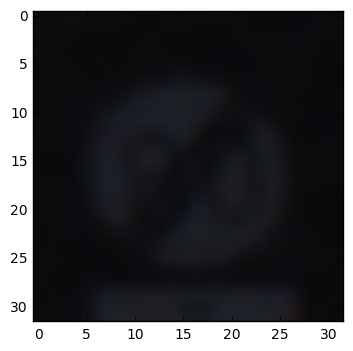

In [30]:
# Images vary widely in their intensity
# Take as an example image 10001(index 10000)
# Which is very dark

img = plt.imshow(X_train[10000])

In [33]:
# Distribution of different signs
print(train_explore.value_counts())

del(train_explore)
del(test_explore)

2     2250
1     2220
13    2160
12    2100
38    2070
10    2010
4     1980
5     1860
25    1500
9     1470
7     1440
8     1410
3     1410
11    1320
18    1200
35    1200
17    1110
31     780
14     780
33     689
15     630
26     600
28     540
23     510
30     450
34     420
6      420
16     420
22     390
36     390
40     360
20     360
21     330
39     300
24     270
29     270
32     240
42     240
41     240
27     240
37     210
19     210
0      210
dtype: int64


With this count difference in mind, I will look at some of the signs for which we have fewer samples to see if they are markely different. Either way, it may be beneficial to generate extra data. that resembles these.

From looking at instances of difference signs, some are circles with digits inside of them. Some of them have varied shapes-- between the triangle and the circle. Others have unusual graphics inside.


From the pictures that I looked at, many of them are centered. One simple process to generate additional data that might help the training process is to set some pixels to 0 on the outer edges 5 pixels out. This helps the algorithm focus on what is important. 

In [36]:
X_train[10].ravel()

array([147, 112, 112, ...,  71,  70,  73], dtype=uint8)

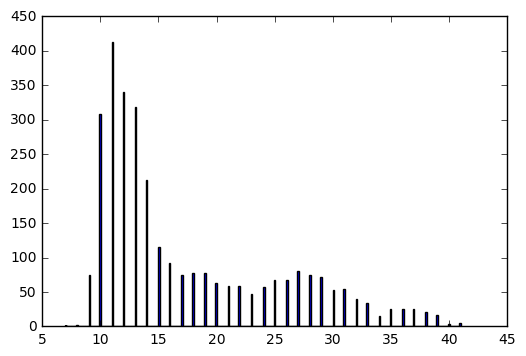

In [37]:
renorm = plt.hist(X_train[10000].ravel(), bins=256)

### Distribution of Average Brightness Stddev Brightness

The brightness is calculated by the formula in the cell below. The approach taken in this section applies this transformation to each pixel of an image and then takes the average across the pixels. I then apply this to each image and plot the results. 

I do samples of 1000-- assuming the training data has been properly mixed of course. There appears to be a bimodal distribution. One with a mean around 50 and another around 120. These two modes probably correspond to the average brightness at night vs day.

Next, we consider the question wehther pixels vary widely in brightness in a single picture. For this, we apply the standard deviation to all the pixels in a picture. It looks like some images have wide variation in intensity of pixels. I won't venture a pattern here.

In [38]:
#Brightness of image
"""
Taken from stack overflow

Photometric/digital ITU BT.709:
Y = 0.2126 R + 0.7152 G + 0.0722 B
"""
brightness = lambda x: 0.2126*x[0] + 0.7152 * x[1] + 0.0722 * x[2]

In [39]:
import numpy as np
def summary_brightness(img, fun):
    reshape = np.reshape(img, (32**2,3))
    return fun(np.apply_along_axis(brightness,axis = 1, arr=reshape))
def avg_brightness(img): 
    return summary_brightness(img, np.mean)
def stddev_brightness(img):
    return summary_brightness(img, np.std)

In [40]:
print("average brightness img 10001: ", avg_brightness(X_train[10000]))
print("average brightness img 11: ", avg_brightness(X_train[10]))

average brightness img 10001:  16.4260341797
average brightness img 11:  122.587939648


In [41]:
#Distribution of avg brightness
def summary_transform(X, fun):
    num_samples = X.shape[0]
    reshape = np.reshape(X,(num_samples,32**2*3))
    return np.apply_along_axis(fun, axis = 1, arr = reshape)

def avg_transform(X):
    return summary_transform(X, avg_brightness)

#Distribution of stddev brightness
def stddev_transform(X):
    return summary_transform(X,stddev_brightness)

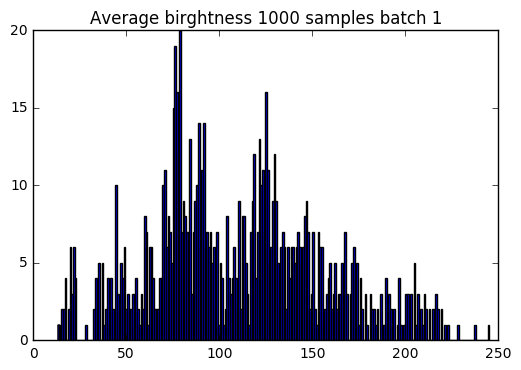

In [42]:
## Some sample plots of average brightness of pixels
plt.title("Average birghtness 1000 samples batch 1")
dummy = plt.hist(avg_transform(X_train[:1000]),bins=256)

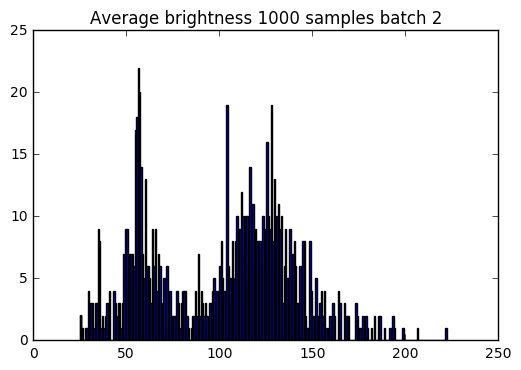

In [43]:
plt.title("Average brightness 1000 samples batch 2")
dummy = plt.hist(avg_transform(X_train[1000:2000]),bins=256)

### Plots of Stddev of Brightness in each picture

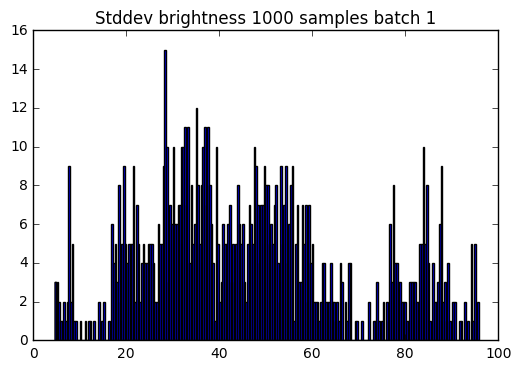

In [44]:
plt.title("Stddev brightness 1000 samples batch 1")
dummy = plt.hist(stddev_transform(X_train[:1000]),bins=256)

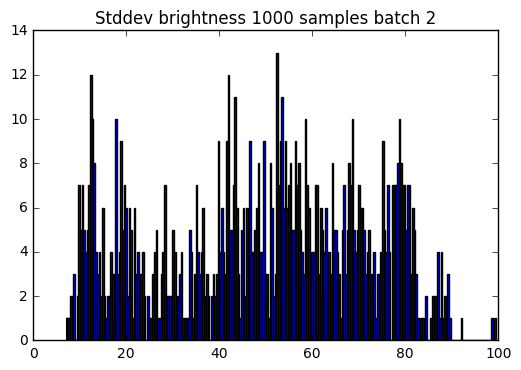

In [45]:
plt.title("Stddev brightness 1000 samples batch 2")
dummy = plt.hist(stddev_transform(X_train[1000:2000]),bins=256)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

## Preprocessing Steps

I plan to only do minimal preprocessing. After all, one of the great properties of neural networks is that it is great at discovering useful features. The preprocessing steps I will do:
1. shuffle the data
1. center the data
 - equalize the variance and make the mean zero like in the tensorflow notebook
 -the only difference is that this will be done over each color
 - this produces nice gradients and speeds up back-propagation
1. add some noise to the data
 - This has been shown to be a nice regularizer
 - It is a nice approximation of l2 normalization and performs better
1. generate additional data

In [4]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

In [5]:
def normalize_color(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    # TODO: Implement Min-Max scaling for grayscale image data
    xmin = np.min(image_data)
    xmax = np.max(image_data)
    a = 0.1
    b = 0.9
    return a + (image_data - xmin) *(b-a) / (xmax - xmin)

In [6]:
import numpy as np
#For a simpler regression problem, I would also scale the test data by the same factors
#as the training data, but the ranges is capped at 255 anyways.

#convert to float
X_train = X_train.astype(float)
X_test = X_test.astype(float)

#center the data and add some gaussian noise

mu, sigma = 0.0, 0.01
for i in range(3):
    X_train[:,:,:,i] = normalize_color(X_train[:,:,:,i]) + \
                       np.random.normal(mu, 
                                        sigma, 
                                        n_train*image_shape[0]*image_shape[1]).reshape(
                                                                                       n_train,
                                                                                       image_shape[0],
                                                                                       image_shape[1]
                                                                                      )
    X_test[:,:,:,i] = normalize_color(X_test[:,:,:,i]) + \
                      np.random.normal(mu, 
                                       sigma, 
                                       n_test*image_shape[0]*image_shape[1]).reshape(
                                                                                      n_test,
                                                                                      image_shape[0],
                                                                                      image_shape[1]
                                                                                      )

In [7]:
#some extemely simple 'generated data'

#steps to use these properly is to copy 
#relvant portions of numpy array-- .copy()
#then apply transform and append them back in 

def insert_black_edges(img):
    img[:5,:] = 0
    img[:,:5] = 0
    img[-5:,:] = 0
    img[:,-5:] = 0

def hide_left_third(img):
    img[:,:11] = 0
    
def hide_right_third(img):
    img[:,-11:] = 0

def hide_top_third(img):
    img[:11,:]=0
    
def hide_bottom_third(img):
    img[-11:,:]=0

In [8]:
accum = np.array([])
accum_target = np.array([])
transforms = [insert_black_edges, hide_left_third,hide_right_third,
              hide_top_third,hide_bottom_third]
for i, func in enumerate(transforms):
    print("In iteration i: ", i)
    print("randomly sample 20% data")
    sample = np.random.choice([False, True],size = (n_train), p=[4./5, 1./5])
    features = X_train[sample].copy()
    
    #Train data
    print("processing ",sample.shape," samples")
    func(features) #mutate the copy
    accum = np.append(accum, features)
    
    #Target data
    target = y_train[sample].copy()
    accum_target = np.append(accum_target, target)
    
X_train = np.append(X_train, accum)
X_train = X_train.reshape([-1,32,32,3])
y_train = np.append(y_train,accum_target)

print("In total added ", accum.shape[0]/32**2/3, " new cells")
print("Total array size is now ", X_train.shape)
del(accum)
del(accum_target)

In iteration i:  0
randomly sample 20% data
processing  (39209,)  samples
In iteration i:  1
randomly sample 20% data
processing  (39209,)  samples
In iteration i:  2
randomly sample 20% data
processing  (39209,)  samples
In iteration i:  3
randomly sample 20% data
processing  (39209,)  samples
In iteration i:  4
randomly sample 20% data
processing  (39209,)  samples
In total added  39195.0  new cells
Total array size is now  (78404, 32, 32, 3)


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:** The first part, I took directly from the tensorflow tutorial. Basically, we squeeze the values so that they lie between som arbitrary a,b. 
 - Note that the 'squeezing' would use maximum and minimum values from the training test on the test set. I felt this wasn't necessary because extreme values are bounded between 0 and 255.

I decided to keep the rgb breakout because I suspect they are useful features. 

The second preprocessing step where I added normal noise is sort of an approximation of l2 regularization. It has also been shown to perform better. 

A standard way to preprocess data is to blank-out sections of data. I've done 5 ways of removing regions, which I apply to a randomly-sampled copy of 20% of the data (with 5 transformations, I double the data size). These preprocessing steps all take advantage of the fact that the images are centered. Some images of superfluous pixes at the border. Another standard way of preprocessing the data appears to have been already done. Some signs have been zoomed into. 

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = 0.2, random_state = 0)

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**  I simply used train_test_split to get my validation set as suggested in the lesson. 

To generate new data, I observed that most images were centered and had superfluous pixels on the border. With this in mind, I removed the border in 5 different ways (details above).

In [10]:
def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    filter1 = tf.Variable(tf.truncated_normal([5,5,3,6], mu, sigma))
    conv1 = tf.nn.conv2d(x,filter1,strides = [1,1,1,1], padding='VALID')
    conv1 = tf.add(conv1, tf.Variable(tf.zeros(6))) #add bias

    # TODO: Activation.
    conv1 = tf.nn.relu(conv1)

    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize = [1,2,2,1], strides=[1,2,2,1], padding = 'VALID')

    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    filter2 = tf.Variable(tf.truncated_normal([5,5,6,16], mu, sigma))
    conv2 = tf.nn.conv2d(conv1, filter2, strides = [1,1,1,1], padding = 'VALID')
    conv2 = tf.add(conv2, tf.Variable(tf.zeros(16)))
    
    # TODO: Activation.
    conv2 = tf.nn.relu(conv2)

    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')

    # TODO: Flatten. Input = 5x5x16. Output = 400.
    flatten = tf.reshape(conv2,[-1,400])
    #flatten = flatten(conv2)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1 = tf.Variable(tf.truncated_normal([400,120], mu, sigma))
    fc1 = tf.add( tf.matmul(flatten, fc1), tf.Variable(tf.zeros(120)))
    
    # TODO: Activation.
    fc1 = tf.nn.relu(fc1)

    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2 = tf.Variable(tf.truncated_normal([120,84],mu, sigma))
    fc2 = tf.add(tf.matmul(fc1,fc2), tf.Variable(tf.zeros(84)))
    
    # TODO: Activation.
    fc2 = tf.nn.relu(fc2)

    # TODO: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3 = tf.Variable(tf.truncated_normal([84,43], mu, sigma))
    fc3 = tf.add(tf.matmul(fc2,fc3), tf.Variable(tf.zeros(43)))
    logits = fc3
    
    return logits

In [10]:
def Net2(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 1: Convolutional. Input = 32x32x3. Output = 32x32x8.
    filter1 = tf.Variable(tf.truncated_normal([5,5,3,8], mu, sigma))
    conv1 = tf.nn.conv2d(x,filter1,strides = [1,1,1,1], padding='SAME')
    conv1 = tf.add(conv1, tf.Variable(tf.zeros(8))) #add bias

    # TODO: Activation.
    conv1 = tf.nn.relu(conv1)

    # TODO: Pooling. Input = 32x32x8. Output = 16x16x8.
    conv1 = tf.nn.max_pool(conv1, ksize = [1,2,2,1], strides=[1,2,2,1], padding = 'SAME')

    # TODO: Layer 2: Convolutional. Output = 16x16x20.
    filter2 = tf.Variable(tf.truncated_normal([5,5,8,20], mu, sigma))
    conv2 = tf.nn.conv2d(conv1, filter2, strides = [1,1,1,1], padding = 'SAME')
    conv2 = tf.add(conv2, tf.Variable(tf.zeros(20)))
    
    # TODO: Activation.
    conv2 = tf.nn.relu(conv2)

    # TODO: Pooling. Input = 16x16x20. Output = 8x8x20.
    conv2 = tf.nn.max_pool(conv2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')

    # TODO: Flatten. Input = 4x4x32. Output = 1280.
    flatten = tf.reshape(conv2,[-1,1280])
    
    # TODO: Layer 3: Fully Connected. Input = 1280. Output = 120.
    fc1 = tf.Variable(tf.truncated_normal([1280,120], mu, sigma))
    fc1 = tf.add( tf.matmul(flatten, fc1), tf.Variable(tf.zeros(120)))
    
    # TODO: Activation.
    fc1 = tf.nn.relu(fc1)

    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2 = tf.Variable(tf.truncated_normal([120,84],mu, sigma))
    fc2 = tf.add(tf.matmul(fc1,fc2), tf.Variable(tf.zeros(84)))
    
    # TODO: Activation.
    fc2 = tf.nn.relu(fc2)

    # TODO: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3 = tf.Variable(tf.truncated_normal([84,43], mu, sigma))
    fc3 = tf.add(tf.matmul(fc2,fc3), tf.Variable(tf.zeros(43)))
    logits = fc3
    
    return logits

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** The final architecture is similar to the original lenet architecture with two changes:
1. I changed the padding setting to same
1. I made the second convolutional layer slightly bigger

In all we have
2 convolution/max pool layers

#### ** Convolution 1:**
32x32x3 -> 32x32x8 
##### ** Max pool 1:**
32x32x8 -> 16x16x8


#### **Convolution 2:**
16x16x8 -> 16x16x20
##### **Max pool 2:**
16x16x20 -> 8x8x20

#### **Flatten**
1280
##### **Fully Connected**
1280 -> 120
##### **Fully Connected**
1280 -> 84
#### **Fully Connected/Softmax**
84 -> 43

I plan on doing three neural nets. One will be the classic lenet. 
One will incorporate a few optimizations.
1. Adamoptimizer
1. nesterov momentum
1. dropout
The third will incorporate all of these things but will simply be bigger because dropout usually requires a bigger net. 
 
 - to try later techniques from inception net

In [11]:
import tensorflow as tf

In [12]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
    
one_hot_y = tf.one_hot(y, 43)

## Define the data pipeline

In [13]:
EPOCHS = 100
BATCH_SIZE = 128

rate = 0.001
mom = 0.1
train_method = 1

logits = Net2(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
if train_method == 1:
    optimizer = tf.train.AdamOptimizer(learning_rate = rate)
elif train_method == 2:
    optimizer = tf.train.MomentumOptimizer(learning_rate = rate, momentum=mom, use_nesterov=True)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation

In [14]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        feed_dict = { x: batch_x, y: batch_y }
        accuracy = sess.run(accuracy_operation, feed_dict)
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the model

In [15]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            feed_dict = {x: batch_x, y: batch_y }
            sess.run(training_operation, feed_dict)
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.793

EPOCH 2 ...
Validation Accuracy = 0.909

EPOCH 3 ...
Validation Accuracy = 0.940

EPOCH 4 ...
Validation Accuracy = 0.955

EPOCH 5 ...
Validation Accuracy = 0.966

EPOCH 6 ...
Validation Accuracy = 0.917

EPOCH 7 ...
Validation Accuracy = 0.969

EPOCH 8 ...
Validation Accuracy = 0.982

EPOCH 9 ...
Validation Accuracy = 0.984

EPOCH 10 ...
Validation Accuracy = 0.978

EPOCH 11 ...
Validation Accuracy = 0.975

EPOCH 12 ...
Validation Accuracy = 0.979

EPOCH 13 ...
Validation Accuracy = 0.976

EPOCH 14 ...
Validation Accuracy = 0.974

EPOCH 15 ...
Validation Accuracy = 0.989

EPOCH 16 ...
Validation Accuracy = 0.992

EPOCH 17 ...
Validation Accuracy = 0.982

EPOCH 18 ...
Validation Accuracy = 0.985

EPOCH 19 ...
Validation Accuracy = 0.989

EPOCH 20 ...
Validation Accuracy = 0.986

EPOCH 21 ...
Validation Accuracy = 0.981

EPOCH 22 ...
Validation Accuracy = 0.992

EPOCH 23 ...
Validation Accuracy = 0.972

EPOCH 24 ...
Validation Accura

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:** 
- optimizer: Adam
- batch size: 128
- epochs: 100
- learning rate: 0.001
- weight initialization: truncated norm with mean: 0 std: 0.1
- centering bounds: 0.1-0.9
- noise added to training data: mean: 0 std: 0.1

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**
I chose to use the lenet architecture primarily because the domain of digit recognition is similarly complex to that of classifying traffic signs. Both have well-defined symbols. The difference between the problem lies in translation/scaling and the coloring. While digit recognition has fewer symbols, there is far more variance in how those symbols are formed. At the same time, those digits in the mnist data set have been centered and are at uniform scale (symbols are roughly the same size). In contrast, the traffic sign data has far more symbols. However, the symbols are not the same size (though they are roughly centered). As I observed previously, it appears that some pictures are duplicated but zoom in or zoom out. The traffic sign data also has more complexity when it comes to coloring. Not only do different symbols vary widely in color, there are pictures that are taken with different lighting. In all, these variations do not seem insurmountable with a similar architecture as the symbols are distinct and the images are relatively clear with little occlusion or distortion. With some of the observations above, I started a set of experiments summarized in the next paragraph. 

### *Note: all experiments are done over 20 epochs with a learning rate of 0.001. I realize that it is hard to predict the 'final' validation accuracy with such a small number of epochs. I do this primarily to familiarize myself with the ideas as well as general rules of thumb.*

1. If I use the vanilla lenet architecture with no data preprocessing and a learning rate of 0.001 the validation accuracy ends up around 0.968 for 20 epochs. 

1. In 20 epochs, the basic changes that I made in preprocessing the data made no noticeable difference (except that it seems to take longer to train). The validation accuracy ended up around 0.966. With increased noise (from stddev noise 0.001 to 0.01), it is still not definitively better, though the max of all observed validation accuracies was better.
 - these changes were adding some noise
 - centering the data

1. The next thing that I tested is basically using the lenet architecture, but applying same padding throughout. This is supposed to help extract more features and improve performance. It appears that this change does improve the validation accuracy over 20 epochs. The improvement is anywhere between 0.4-0.8%.

1. Adding the generated data raised the performance another 0.8-1.0% to ~98.3%.
 - The generated data followed from the observation that there was often superfluous pixels around the edge of the images. To train the net to be able to ignore these pixels, I inserted various types of cropping along the edges.

1. Increasing the size of the net by adding one more layer of convolution and pooling and adding dropout. With only one more layer, it is questionable whether the net is large enough so that there would be noticeable improvements in training. After 20 epochs, the validation accuracy is only around 90% and it's not clear how much more the model will improve. After 100 epochs, 
 - Note: when training with a rate of 0.01, the gradiant does not improve. 
 - tried to improve speed by using momentum. This turned out to be ineffective. Early iterations had the validation accuracy starting at close to 0%. After 15 hours of training, the validation accuracy was around 87.5%. It's not clear if this strategy was a 'failure' because the validation accuracy was still improving. However, it have have taken a few days of training to find out where the asymptote was/where it begins overfitting.

1. I was finally able to reach my goal of above 99%. To accomplish this, I did the experiments below.
  - add even more replicated data-- this failed. I thought pictures in which half the pixels were removed might improve the results because some signs are symmetrical and some aren't. However, it turned out that this just introduced noise into the training data.
  - increase the number of training epochs to 100

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [16]:
import cv2
import matplotlib.image as mpimg
new_test_images = ['noright.jpg','one way.png', 'stop.jpg', 'yield.png', 'warning-sign-slippery-road.jpg']
some_images = []
for image in new_test_images:
    img_read = cv2.imread(image)
    img_read = cv2.cvtColor(img_read, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img_read, (32,32)) #import image and make it 32x32
    some_images.append(img)
some_images = np.array(some_images)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:** All the signs except for the first have counterparts in the Germany signs. Possible points of difficulty:
1. The stop sign is not centered.
1. All the images take up the entire frame, which might confuse the algorithm since the net has been trained extensively and may expect some superfluous space. 

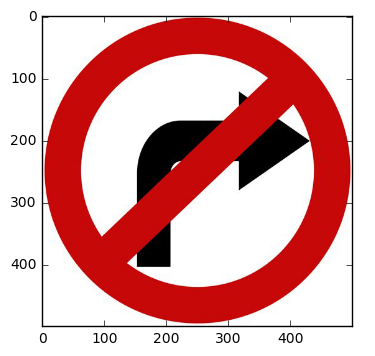

In [69]:
test = cv2.imread('noright.jpg')
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
plt.imshow(test)

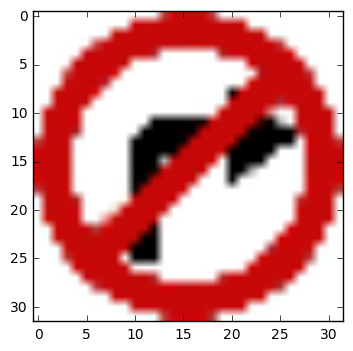

In [70]:
plt.imshow(some_images[0])

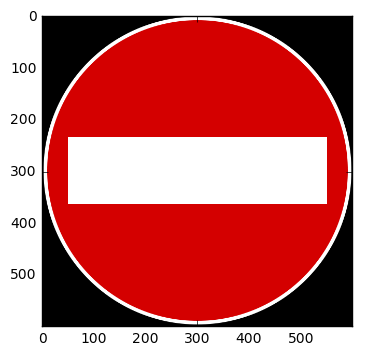

In [71]:
test = cv2.imread('one way.png')
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
plt.imshow(test)

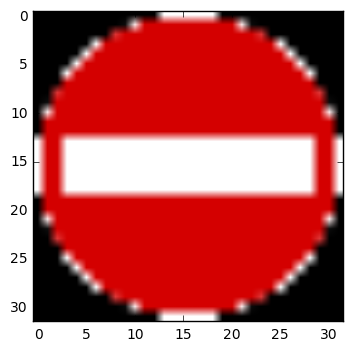

In [72]:
plt.imshow(some_images[1])

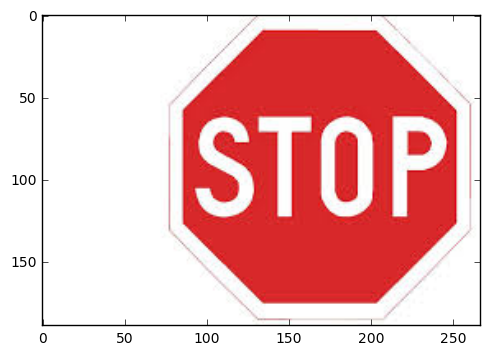

In [73]:
test = cv2.imread('stop.jpg')
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
plt.imshow(test)

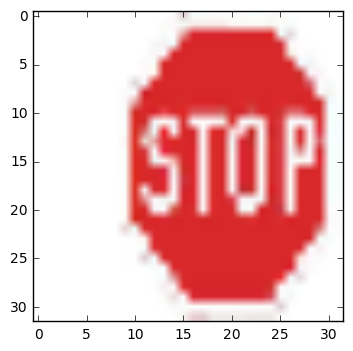

In [74]:
plt.imshow(some_images[2])

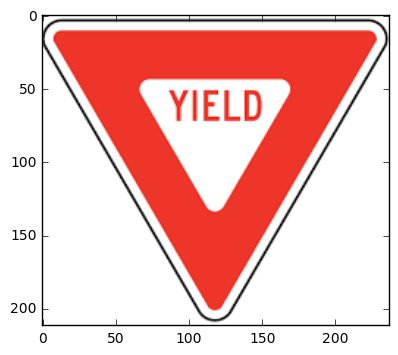

In [75]:
test = cv2.imread('yield.png')
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
plt.imshow(test)

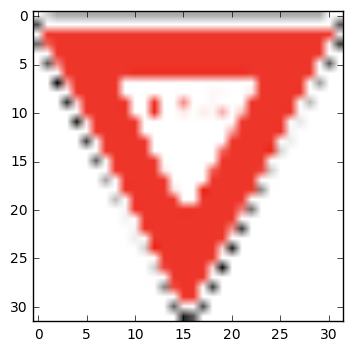

In [76]:
plt.imshow(some_images[3])

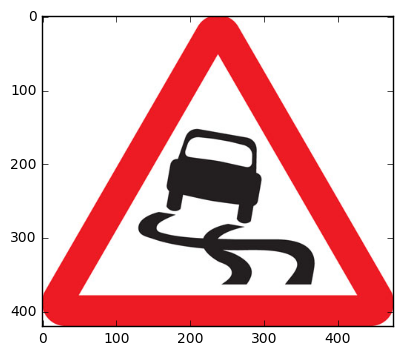

In [77]:
test = cv2.imread('warning-sign-slippery-road.jpg')
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
plt.imshow(test)

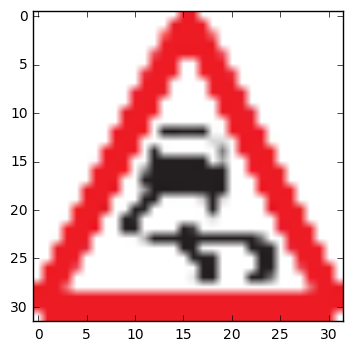

In [78]:
plt.imshow(some_images[4])

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:** Using the strictest evaluation of error, the model predicts 60% correctly. The two signs were it failed were "no right turn" and "beware of slippery road." In all, these seem to me satisfactory results. Even though "no right turn" was incorrect, the sign the model predicted was very close visually. The meaning was also similar, "dangerous curve to the right."

These set of experiments raise the question of generality. Does this learning apply to signs that we haven't seen for whatever reason? The answer is in the positive. 

In [17]:
some_images = some_images.astype(float)
for i in range(3):
    some_images[:,:,:,i] = normalize_color(some_images[:,:,:,i])

In [55]:
tf.reset_default_graph()

#initialize variables in network
x = tf.placeholder(tf.float32)
logits = Net2(x)
predictions = tf.nn.softmax(logits)

#saver to restore values
saver = tf.train.Saver()

In [56]:
save_file = '/Users/kevinko/pycharmprojects/carnd-traffic-sign-classifier-project/lenet'

with tf.Session() as sess:
    saver.restore(sess, save_file)
    
    predictions = sess.run(tf.nn.top_k(predictions, k = 3), feed_dict = {x: some_images})
    print(predictions)

TopKV2(values=array([[  1.00000000e+00,   6.94478980e-12,   8.34517595e-14],
       [  1.00000000e+00,   1.80709359e-09,   3.50354210e-19],
       [  1.00000000e+00,   2.16645941e-30,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  5.38764954e-01,   4.43414718e-01,   1.66651290e-02]], dtype=float32), indices=array([[20, 35, 38],
       [17, 15,  1],
       [14, 17,  0],
       [13,  0,  1],
       [ 1, 20, 29]], dtype=int32))


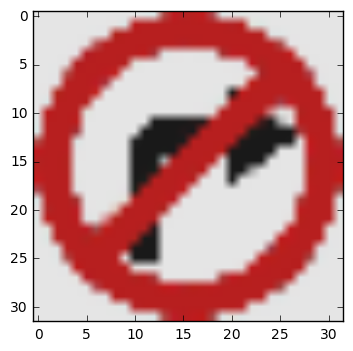

In [47]:
plt.imshow(some_images[0])

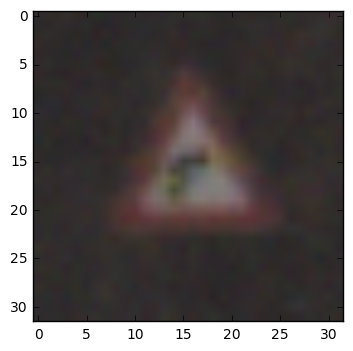

In [57]:
plt.imshow(X_train[y_train==20][0])

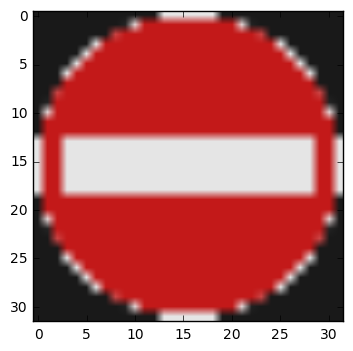

In [58]:
plt.imshow(some_images[1])

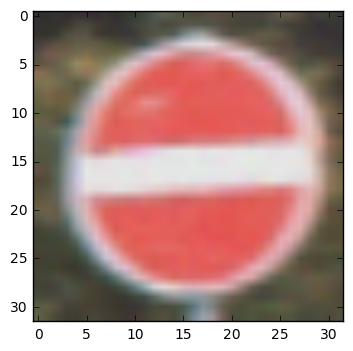

In [59]:
plt.imshow(X_train[y_train==17][0])

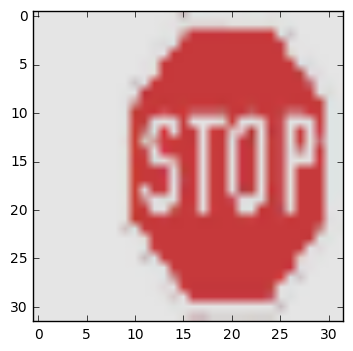

In [60]:
plt.imshow(some_images[2])

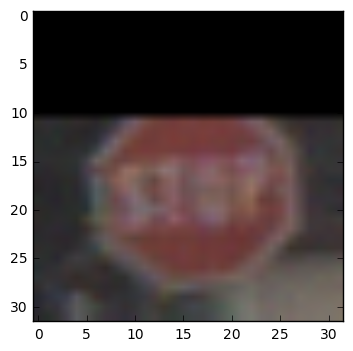

In [61]:
plt.imshow(X_train[y_train==14][0])

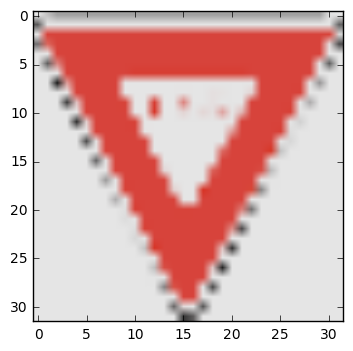

In [62]:
plt.imshow(some_images[3])

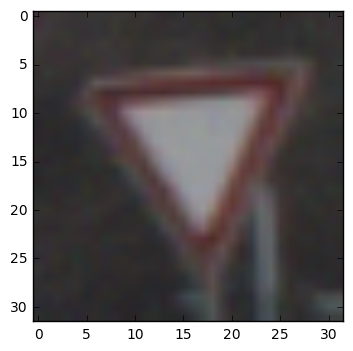

In [64]:
plt.imshow(X_train[y_train==13][0])

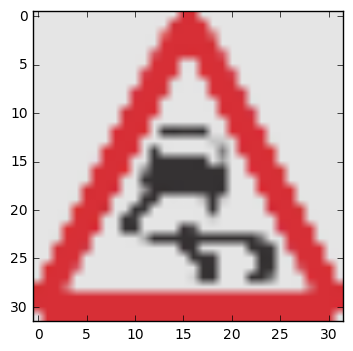

In [65]:
plt.imshow(some_images[4])

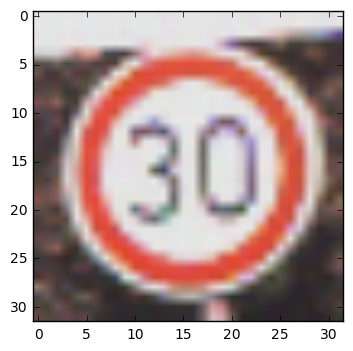

In [68]:
plt.imshow(X_train[y_train==1][0])

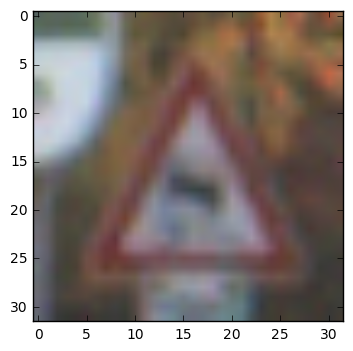

In [77]:
plt.imshow(X_train[y_train==23][0])

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:** The model is certain of all of its predictions except for the last image. The corresponding sign, 23, is not in the top 5 even though it looks the same as the actual sign. Moreover, it's second place prediction seems far better to the human eye than the first prediction even through their probabilities are similar. 

The other false prediction is acceptable in that Germany does not seem to have a sign that means exactly the same thing. Moreover the sign that it predicted has a similar meaning.

In [69]:
tf.reset_default_graph()

#initialize variables in network
x = tf.placeholder(tf.float32)
logits = Net2(x)
predictions = tf.nn.softmax(logits)

#saver to restore values
saver = tf.train.Saver()

In [70]:
save_file = '/Users/kevinko/pycharmprojects/carnd-traffic-sign-classifier-project/lenet'

with tf.Session() as sess:
    saver.restore(sess, save_file)
    
    predictions = sess.run(tf.nn.top_k(predictions, k = 5), feed_dict = {x: some_images})
    print(predictions)

TopKV2(values=array([[  1.00000000e+00,   6.94478980e-12,   8.34517595e-14,
          6.58186249e-18,   7.66049703e-20],
       [  1.00000000e+00,   1.80709359e-09,   3.50354210e-19,
          2.23073081e-24,   1.00645047e-26],
       [  1.00000000e+00,   2.16645941e-30,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  5.38764954e-01,   4.43414718e-01,   1.66651290e-02,
          1.15149515e-03,   2.61397849e-06]], dtype=float32), indices=array([[20, 35, 38, 41, 23],
       [17, 15,  1, 13,  4],
       [14, 17,  0,  1,  2],
       [13,  0,  1,  2,  3],
       [ 1, 20, 29,  7, 11]], dtype=int32))


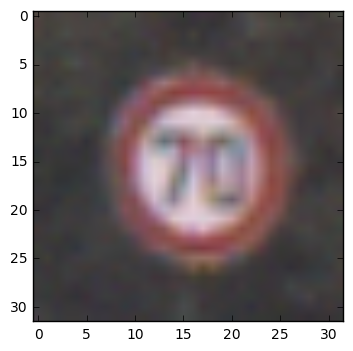

In [76]:
plt.imshow(X_train[y_train==4][0])

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.